In [59]:
!pip install uncertainties

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
#from uncertainties import ufloat
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
plt.rcParams["font.family"] = "serif"
import matplotlib.ticker as ticker


In [61]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Medición 1

In [62]:
df = pd.read_csv("/content/drive/MyDrive/Mod Young/cod mod young vsc/mediciones24-2/med1-24-2-acero-inoxidable-37cm0.csv")

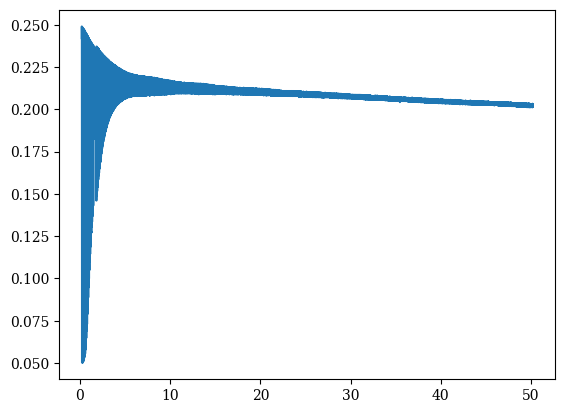

In [63]:
df.columns = ["t","V"]
plt.plot(df["t"], df["V"])


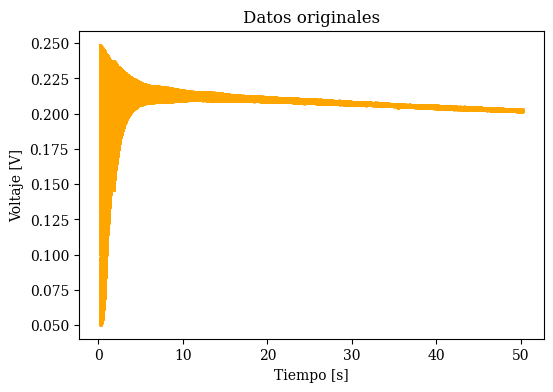

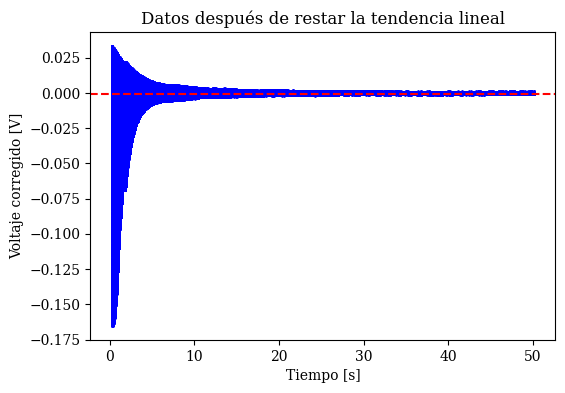

Ecuación de la recta ajustada: V(t) = -0.000267 * t + 0.215536
mean: -0.0006360279782799932


In [64]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t"], df_tail["V"], 1)

recta_ajustada = np.polyval(p, df["t"])

df["V1_corregido"] = df["V"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V1_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V1_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V1_corregido'])}")

In [65]:
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d

In [66]:
t1 = df["t"].to_numpy()
v1 = df["V1_corregido"].to_numpy()

In [67]:
def calculate_absolute_accuracy(reading):
    # Example values from the table for the 10V range
    range_value = 10  # Nominal range positive full scale
    residual_gain_error = 75*(10**-6)  # ppm of reading
    gain_tempoo = 7.3*(10**-6)  # ppm/°C
    temp_change_internal_cal = 5  # Example temperature change in °C
    reference_tempoo = 5*(10**-6)  # ppm/°C
    temp_change_external_cal = 5  # Example temperature change in °C
    residual_offset_error = 20*(10**-6)  # ppm of range
    offset_tempoo = 34*(10**-6)  # ppm of range/°C
    inl_error = 76*(10**-6)  # ppm of range
    random_noise = 295*(10**-6)  # µVrms

    # Calculate GainError
    gain_error = residual_gain_error + gain_tempoo * temp_change_internal_cal + reference_tempoo * temp_change_external_cal

    # Calculate OffsetError
    offset_error = residual_offset_error + offset_tempoo * temp_change_internal_cal + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy

In [68]:
from scipy.signal import savgol_filter

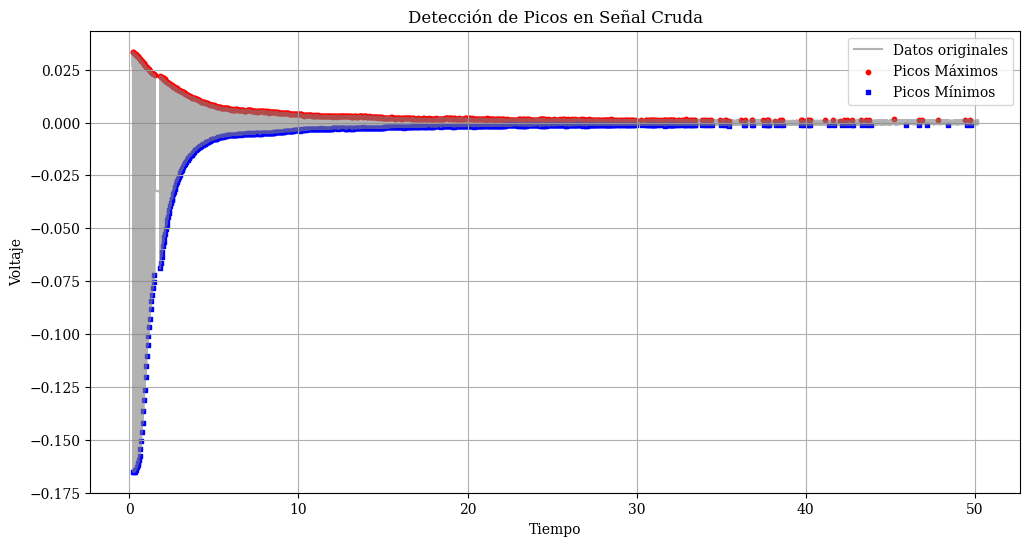

In [69]:
voltaje = v1 - np.mean(v1)
peaks_max, _ = find_peaks(voltaje, prominence=0.002)
peaks_min, _ = find_peaks(-voltaje, prominence=0.002)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t_max = t1[peaks_max]
V_max = v1[peaks_max]

t_min = t1[peaks_min]
V_min = v1[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t1, v1, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
errorVmax = np.maximum(calculate_absolute_accuracy(V_max), np.std(V_max)/10)  # Evitar incertidumbres subestimadas
errorVmin = np.maximum(calculate_absolute_accuracy(V_min), np.std(V_min)/10)

<ipython-input-71-7d58309025e1>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


alfa 0.30675198520106367
Ajuste para picos máximos:
A = 0.0339, α = 0.3068 +- 0.0018, C = 0.0016
Chi-cuadrado (χ²): 26.2394
Chi-cuadrado reducido (χ²/ν): 0.0349
p-valor: 1.0000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


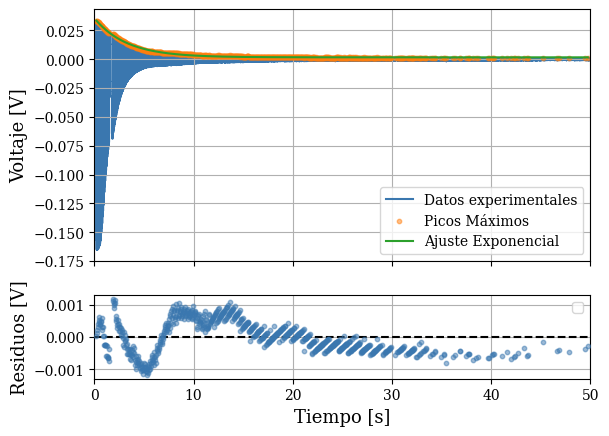

In [71]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max1 = np.linspace(min(t_max), max(t_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)

V_fit_max1 = exponencial(t_fit_max1, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V_max - exponencial(t_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t1, v1, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max1, V_fit_max1, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

In [72]:
def calcular_transformada_fourier(tiempo, voltaje):
    # Número de puntos
    N = len(tiempo)

    # Espaciado en el tiempo
    dt = tiempo[1] - tiempo[0]

    # Eliminar el componente de DC (restar la media)
    voltaje_sin_dc = voltaje - np.mean(voltaje)

    # Calculamos la Transformada de Fourier
    fft_result = np.fft.fft(voltaje_sin_dc)

    # Frecuencias correspondientes
    frecuencias = np.fft.fftfreq(N, dt)

    # Solo nos interesan las frecuencias positivas
    frecuencias_positivas = frecuencias[:N//2]
    fft_positivo = 2.0/N * np.abs(fft_result[:N//2])

    return frecuencias_positivas, fft_positivo

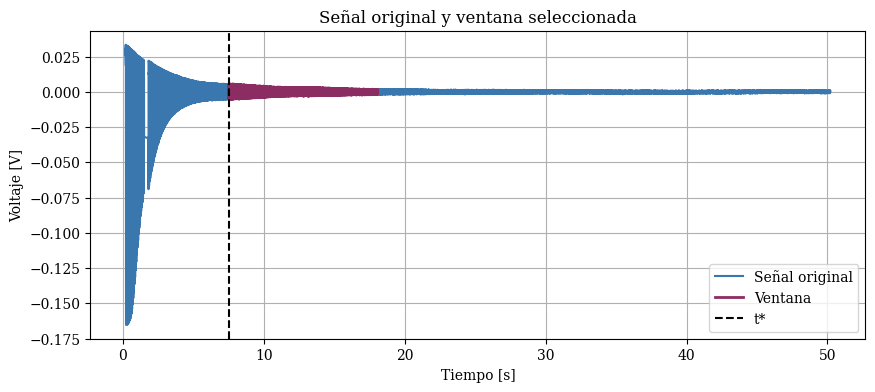

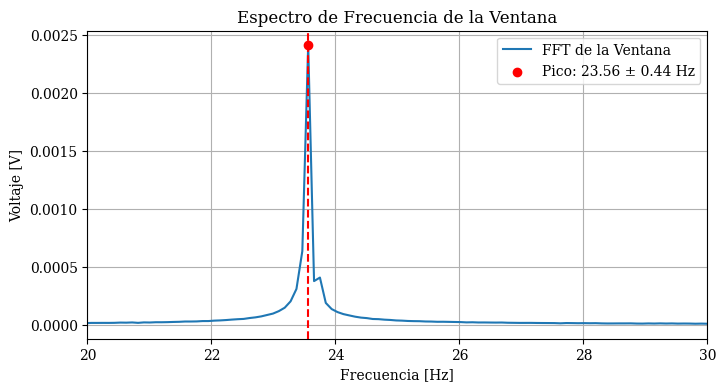

In [73]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t1, v1)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t1, t_star)
idx_end = idx_start + int(N * T * (len(t1) / max(t1)))

ventana = v1[idx_start:idx_end]
t_ventana = t1[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t1, v1, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 30)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()


In [74]:
L = 37/100
alpha = 0.3393
d = 0.6/100
rho = (123/1000)*(1/(L))  #del cobr  # kg/m

f = 23.53

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.44 #
alpha_err = 0.0023 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 173.20+/-6.84 GPa


# Medicion 2

In [75]:
df = pd.read_csv("/content/drive/MyDrive/Mod Young/cod mod young vsc/mediciones24-2/med2-24-2-acero-inoxidable-30cm0.csv")

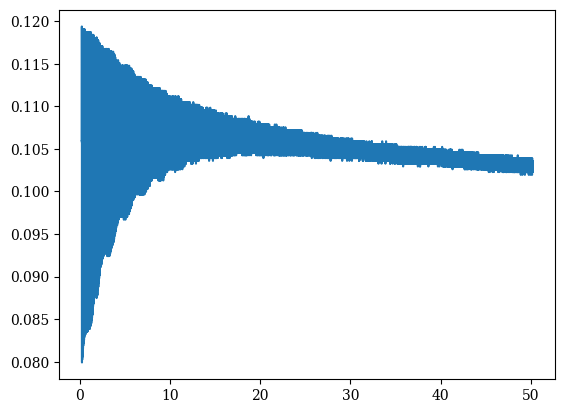

In [76]:
df.columns = ["t2","V2"]
plt.plot(df["t2"], df["V2"])

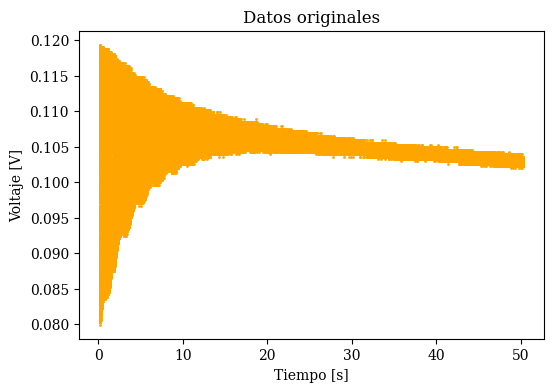

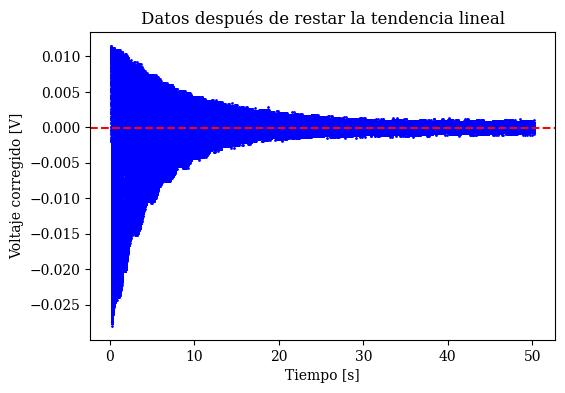

Ecuación de la recta ajustada: V(t) = -0.000099 * t + 0.107888
mean: -4.207138969002563e-05


In [77]:
plt.figure(figsize=(6, 4))
plt.plot(df["t2"], df["V2"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t2"], df_tail["V2"], 1)

recta_ajustada = np.polyval(p, df["t2"])

df["V2_corregido"] = df["V2"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t2"], df["V2_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V2_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V2_corregido'])}")

In [78]:
t2 = df["t2"].to_numpy()
v2 = df["V2_corregido"].to_numpy()

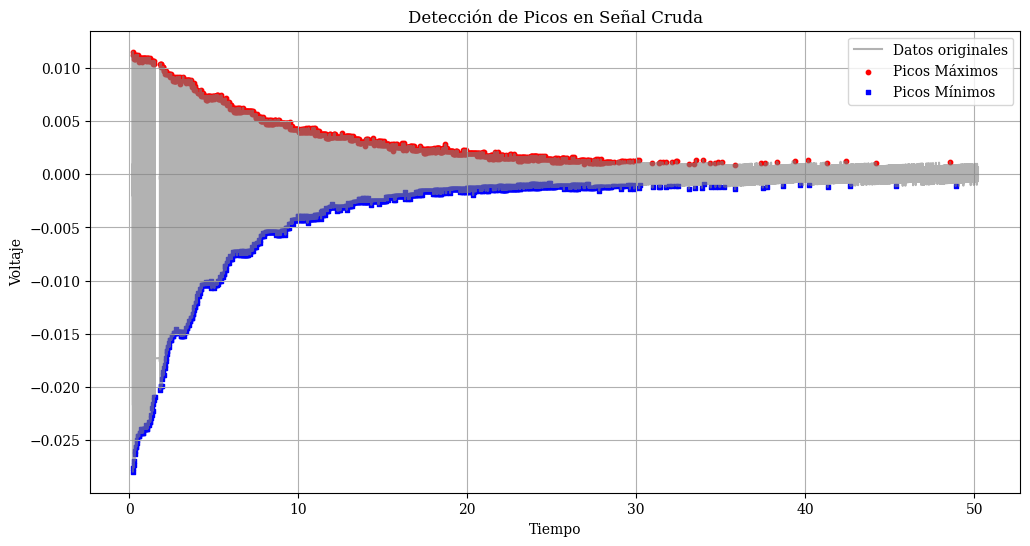

In [79]:
peaks_max, _ = find_peaks(v2, prominence=0.002)
peaks_min, _ = find_peaks(-v2, prominence=0.002)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t2_max = t2[peaks_max]
V2_max = v2[peaks_max]

t2_min = t2[peaks_min]
V2_min = v2[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t2, v2, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t2_max, V2_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t2_min, V2_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
errorVmax = calculate_absolute_accuracy(V2_max)# Evitar incertidumbres subestimadas
errorVmin = calculate_absolute_accuracy(V2_min)

<ipython-input-81-e10674f2f3f7>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


alfa 0.11383765981765565
Ajuste para picos máximos:
A = 0.0112, α = 0.1138 +- 0.0007, C = 0.0008
Chi-cuadrado (χ²): 5.7900
Chi-cuadrado reducido (χ²/ν): 0.0058
p-valor: 1.0000


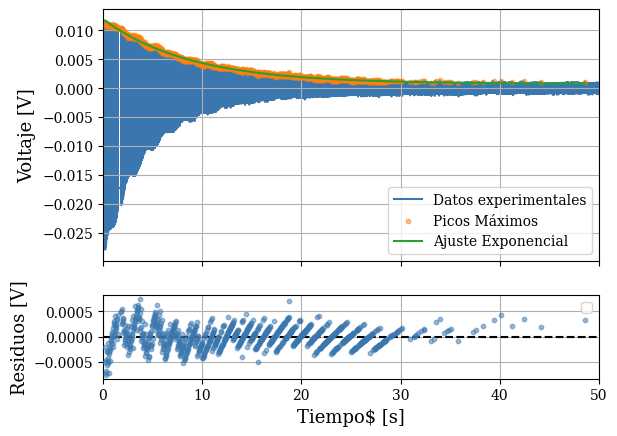

In [81]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max2 = np.linspace(min(t2_max), max(t2_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t2_max, V2_max,
    p0=[max(V2_max), 0.1, min(V2_max)], sigma=errorVmax)

V_fit_max2 = exponencial(t_fit_max2, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V2_max - exponencial(t2_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t2, v2, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t2_max, V2_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max2, V_fit_max2, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t2_max, residuos_max, color='#3a77af',alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo$ [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t2_max, *popt_max)
residuos = V2_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t2_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

<ipython-input-82-cfb0e926158f>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


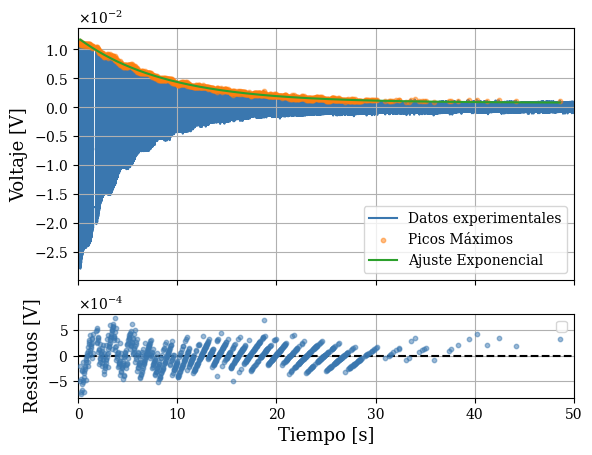

Ajuste para picos máximos:
A = 0.0112, α = 0.1138 ± 0.0007, C = 0.0008
Chi-cuadrado (χ²): 5.7900
Chi-cuadrado reducido (χ²/ν): 0.0058
p-valor: 1.0000


In [82]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max2 = np.linspace(min(t2_max), max(t2_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t2_max, V2_max,
    p0=[max(V2_max), 0.1, min(V2_max)], sigma=errorVmax)

V_fit_max2 = exponencial(t_fit_max2, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax = popt_max[1]

residuos_max = V2_max - exponencial(t2_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t2, v2, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t2_max, V2_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max2, V_fit_max2, color='#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0, 50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t2_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

# Aplicar notación científica en el eje Y
ax1[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

ax1[1].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()

# Predicción y residuos
y_predicho = exponencial(t2_max, *popt_max)
residuos = V2_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t2_max) - len(popt_max)
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} ± {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")


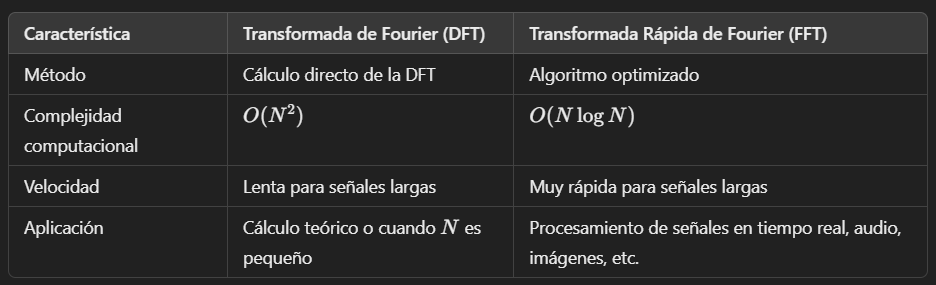

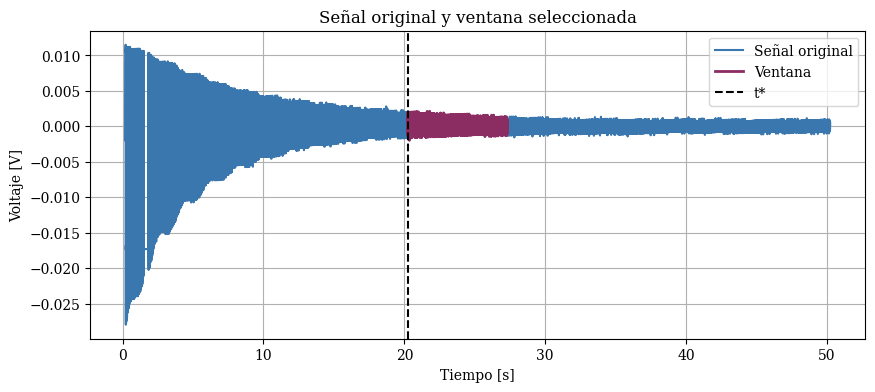

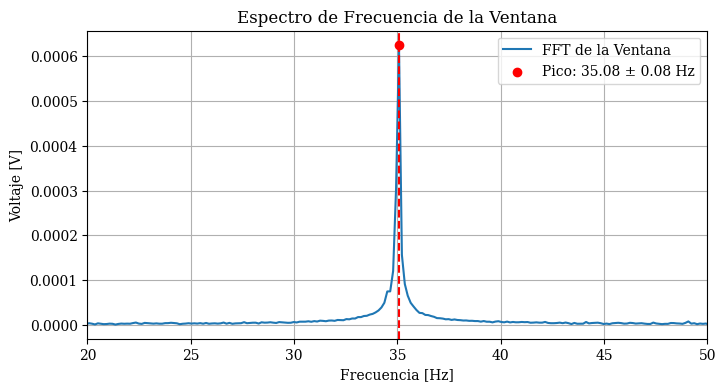

In [83]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t2, v2)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t2, t_star)
idx_end = idx_start + int(N * T * (len(t2) / max(t2)))

ventana = v2[idx_start:idx_end]
t_ventana = t2[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t2, v2, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 50)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()

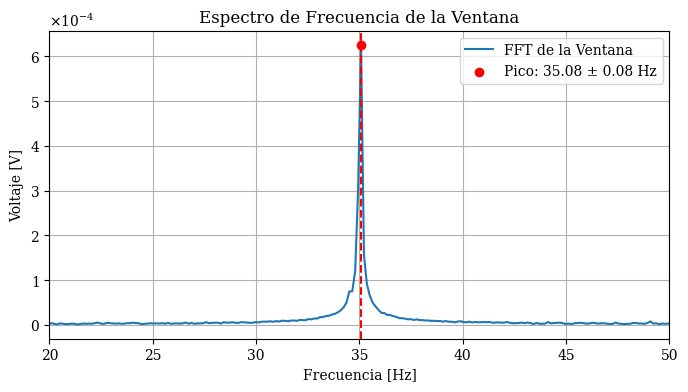

In [84]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')

plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 50)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()

# Aplicar notación científica al eje Y con 1 cifra significativa
ax = plt.gca()
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)  # Activa la notación científica
formatter.set_powerlimits((0, 0))  # Fuerza la notación científica en todo el rango
ax.yaxis.set_major_formatter(formatter)

plt.show()



In [85]:
L = 30/100
alpha = 0.1143 # 0.1143 +- 0.0018
d = 0.6/100
rho = (123/1000)*(1/(L))  #del cobr  # kg/m

f = 35.08

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.08 #
alpha_err = 0.0018 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 205.20+/-3.20 GPa


# Medicion 3


In [86]:
df = pd.read_csv("/content/drive/MyDrive/Mod Young/cod mod young vsc/mediciones24-2/med3-24-2-acero-inoxidable-30cm0.csv")

In [87]:
df.columns = ["t3","V3"]

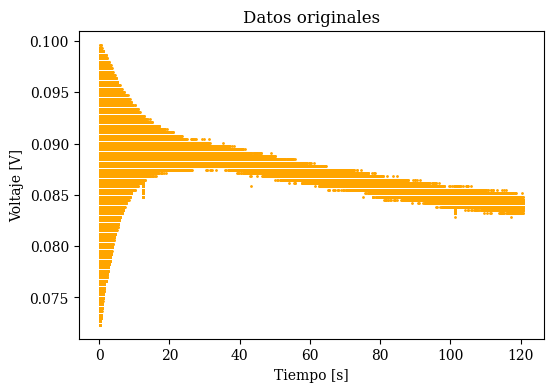

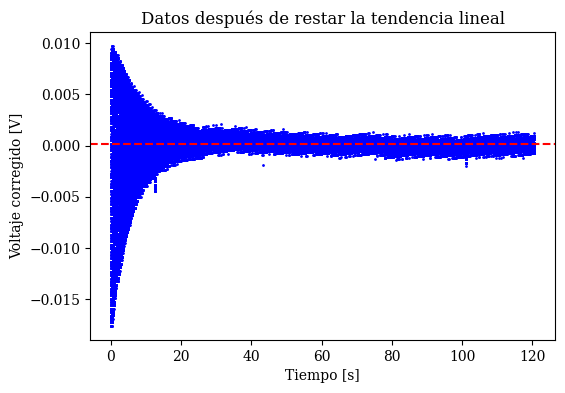

Ecuación de la recta ajustada: V(t) = -0.000050 * t + 0.089928
mean: 0.00013969997376476933


In [88]:
plt.figure(figsize=(6, 4))
plt.plot(df["t3"], df["V3"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t3"], df_tail["V3"], 1)

recta_ajustada = np.polyval(p, df["t3"])

df["V3_corregido"] = df["V3"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t3"], df["V3_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V3_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V3_corregido'])}")

In [89]:
t3 = df["t3"].to_numpy()
v3 = df["V3_corregido"].to_numpy()

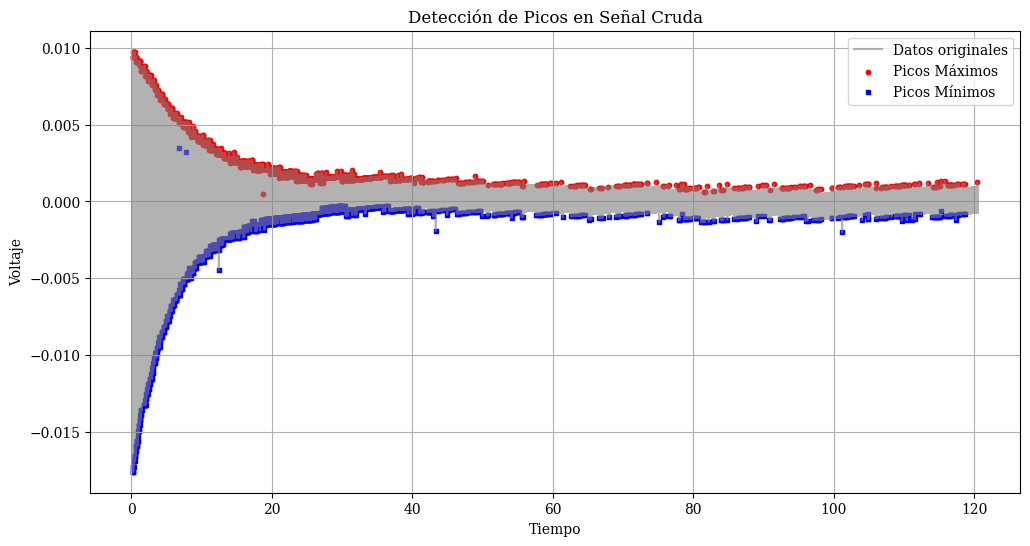

In [90]:
peaks_max, _ = find_peaks(v3, prominence=0.0018)
peaks_min, _ = find_peaks(-v3, prominence=0.0018)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t3_max = t3[peaks_max]
V3_max = v3[peaks_max]

t3_min = t3[peaks_min]
V3_min = v3[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t3, v3, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t3_max, V3_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t3_min, V3_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
errorVmax = np.maximum(calculate_absolute_accuracy(V3_max), np.std(V3_max)/10)  # Evitar incertidumbres subestimadas
errorVmin = np.maximum(calculate_absolute_accuracy(V3_min), np.std(V3_min)/10)

<ipython-input-92-1edf59d7e59d>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


alfa 0.1158594556298963
Ajuste para picos máximos:
A = 0.0091, α = 0.1159 +- 0.0006, C = 0.0011
Chi-cuadrado (χ²): 7.5799
Chi-cuadrado reducido (χ²/ν): 0.0049
p-valor: 1.0000


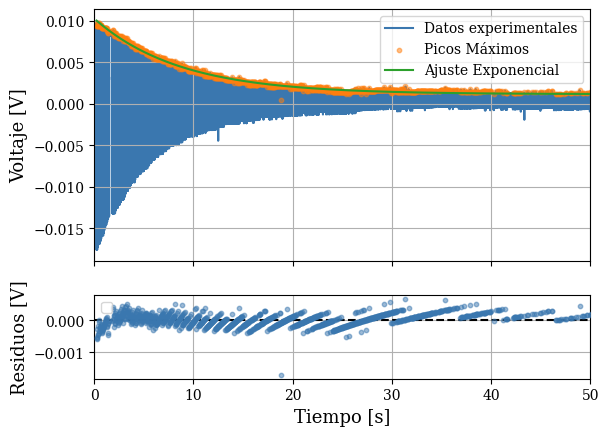

In [92]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max3 = np.linspace(min(t3_max), max(t3_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t3_max, V3_max,
    p0=[max(V3_max), 0.1, min(V3_max)], sigma=errorVmax)

V_fit_max3 = exponencial(t_fit_max3, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V3_max - exponencial(t3_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t3, v3, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t3_max, V3_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max3, V_fit_max3, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t3_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t3_max, *popt_max)
residuos = V3_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t3_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

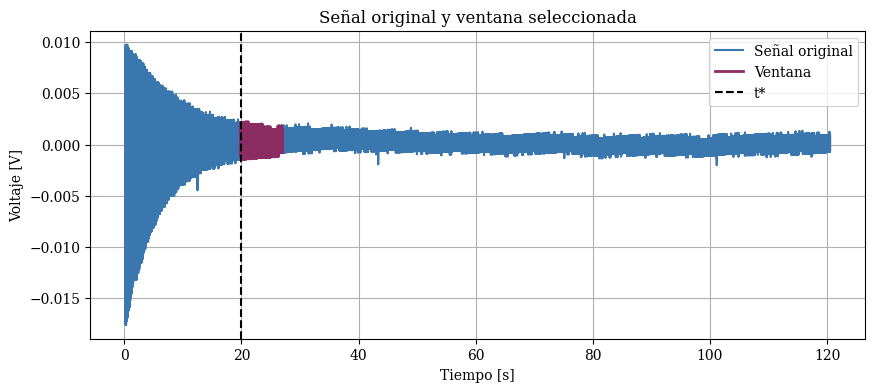

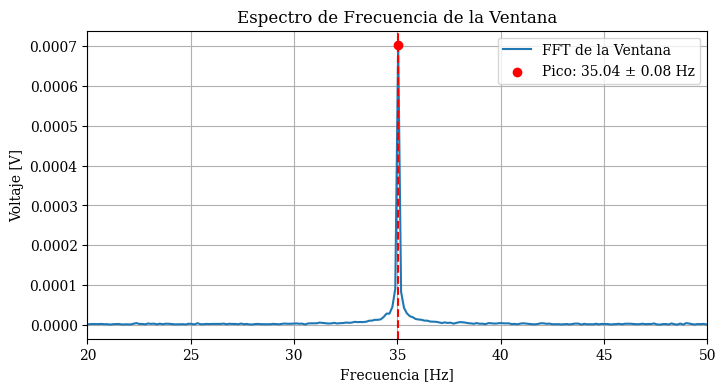

In [93]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t3, v3)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t3, t_star)
idx_end = idx_start + int(N * T * (len(t3) / max(t3)))

ventana = v3[idx_start:idx_end]
t_ventana = t3[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t3, v3, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 50)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()

In [94]:
L = 30/100
alpha = 0.1143 # 0.1143 +- 0.0018
d = 0.6/100
rho = (123/1000)*(1/(L))  #del cobr  # kg/m

f = 35.04

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.08 #
alpha_err = 0.0018 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 204.73+/-3.20 GPa


# Medicion 6 - cobre

In [95]:
df = pd.read_csv("/content/drive/MyDrive/Mod Young/cod mod young vsc/mediciones24-2/med6-24-2-cobre-22-7cm0.csv")

In [96]:
df.columns = ["t6","V6"]

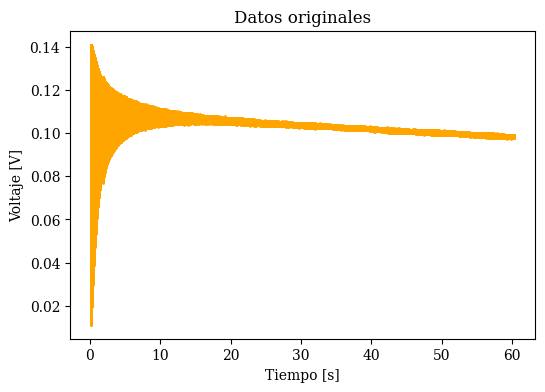

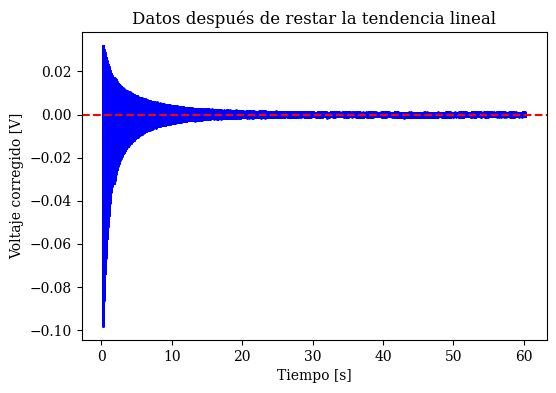

Ecuación de la recta ajustada: V(t) = -0.000181 * t + 0.109209
mean: -0.00019592531665555283


In [97]:
plt.figure(figsize=(6, 4))
plt.plot(df["t6"], df["V6"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t6"], df_tail["V6"], 1)

recta_ajustada = np.polyval(p, df["t6"])

df["V6_corregido"] = df["V6"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t6"], df["V6_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V6_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V6_corregido'])}")

In [98]:
t6 = df["t6"].to_numpy()
v6 = df["V6_corregido"].to_numpy()

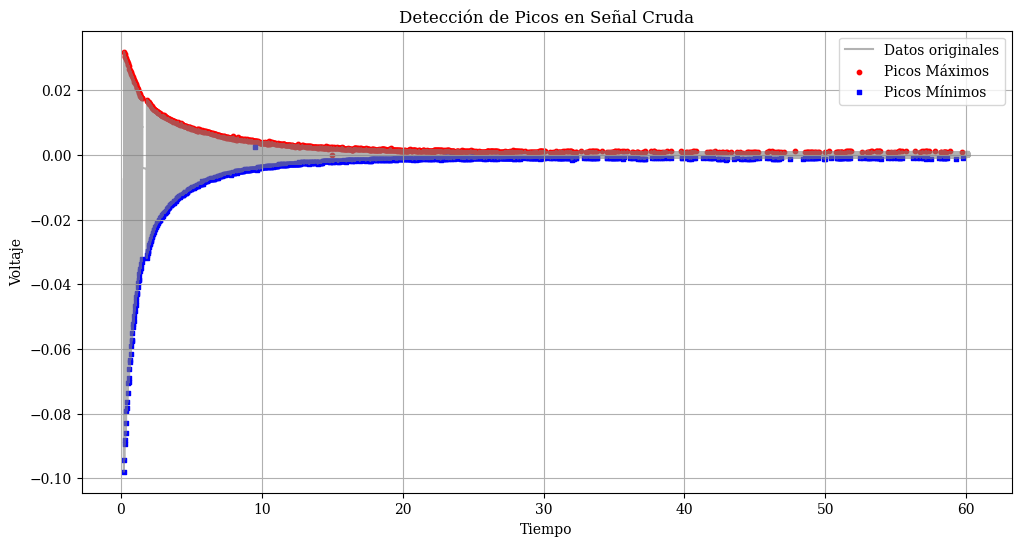

In [99]:
peaks_max, _ = find_peaks(v6, prominence=0.0018)
peaks_min, _ = find_peaks(-v6, prominence=0.0018)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t6_max = t6[peaks_max]
V6_max = v6[peaks_max]

t6_min = t6[peaks_min]
V6_min = v6[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t6, v6, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t6_max, V6_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t6_min, V6_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
errorVmax = np.maximum(calculate_absolute_accuracy(V6_max), np.std(V6_max)/10)  # Evitar incertidumbres subestimadas
errorVmin = np.maximum(calculate_absolute_accuracy(V6_min), np.std(V6_min)/10)

<ipython-input-101-6d87d1d1cb6d>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


alfa 0.2751524403976466
Ajuste para picos máximos:
A = 0.0276, α = 0.2752 +- 0.0022, C = 0.0014
Chi-cuadrado (χ²): 71.7807
Chi-cuadrado reducido (χ²/ν): 0.0956
p-valor: 1.0000


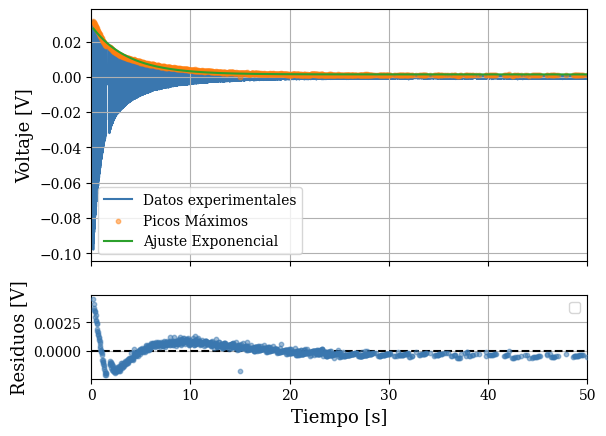

In [101]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max = np.linspace(min(t6_max), max(t6_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t6_max, V6_max,
    p0=[max(V6_max), 0.1, min(V6_max)], sigma=errorVmax)

V_fit_max = exponencial(t_fit_max, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V6_max - exponencial(t6_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t6, v6, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t6_max, V6_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max, V_fit_max, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t6_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t6_max, *popt_max)
residuos = V6_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

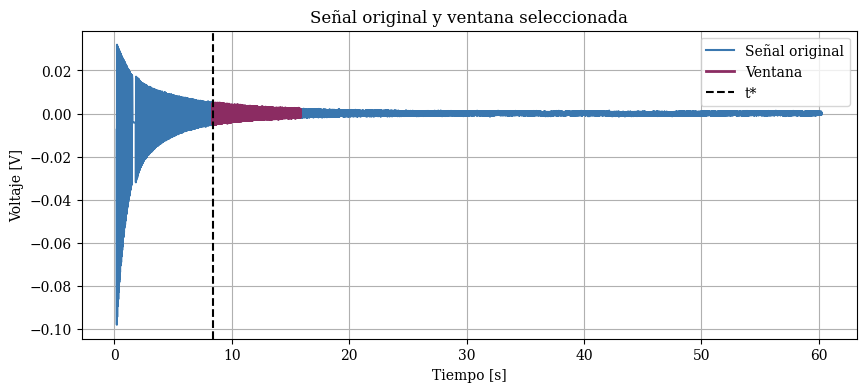

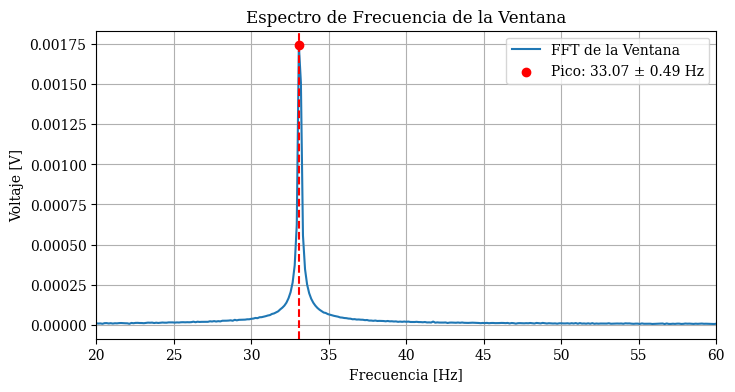

In [102]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t6, v6)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t6, t_star)
idx_end = idx_start + int(N * T * (len(t6) / max(t6)))

ventana = v6[idx_start:idx_end]
t_ventana = t6[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t6, v6, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 60)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()

In [103]:
L = 22.7/100
alpha = 0.2752 # 0.2752 +- 0.0022
d = 0.5/100
rho = (77/1000)*(1/(L))  #del cobr  # kg/m

f = 33.07

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.49 #
alpha_err = 0.0022 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 102.55+/-3.63 GPa


# Medicion 8 - cobre

In [104]:
df = pd.read_csv("/content/drive/MyDrive/Mod Young/cod mod young vsc/mediciones24-2/med8-24-2-cobre-22-7cm0.csv")

In [105]:
df.columns = ["t8","V8"]

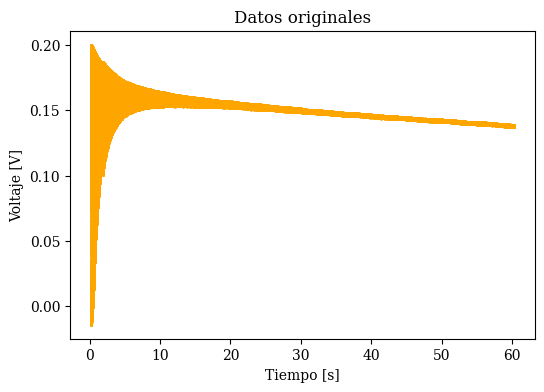

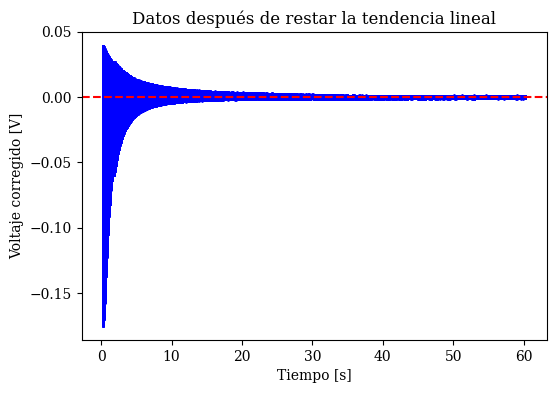

Ecuación de la recta ajustada: V(t) = -0.000381 * t + 0.161022
mean: 6.41574837192579e-05


In [106]:
plt.figure(figsize=(6, 4))
plt.plot(df["t8"], df["V8"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t8"], df_tail["V8"], 1)

recta_ajustada = np.polyval(p, df["t8"])

df["V8_corregido"] = df["V8"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t8"], df["V8_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V8_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V8_corregido'])}")

In [107]:
t8 = df["t8"].to_numpy()
v8 = df["V8_corregido"].to_numpy()

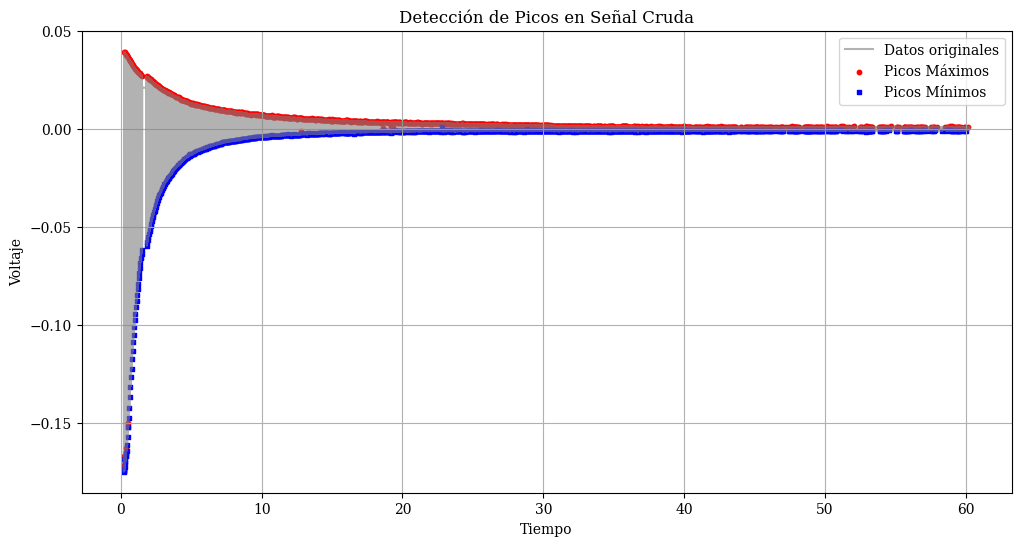

In [108]:
peaks_max, _ = find_peaks(v8, prominence=0.0018)
peaks_min, _ = find_peaks(-v8, prominence=0.0018)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t8_max = t8[peaks_max]
V8_max = v8[peaks_max]

t8_min = t8[peaks_min]
V8_min = v8[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t8, v8, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t8_max, V8_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t8_min, V8_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
errorVmax = np.maximum(calculate_absolute_accuracy(V8_max), np.std(V8_max)/10)  # Evitar incertidumbres subestimadas
errorVmin = np.maximum(calculate_absolute_accuracy(V8_min), np.std(V8_min)/10)

<ipython-input-110-571aea3aef4b>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


alfa 0.047945879935862606
Ajuste para picos máximos:
A = 0.0132, α = 0.0479 +- 0.0189, C = -0.0010
Chi-cuadrado (χ²): 34779.0179
Chi-cuadrado reducido (χ²/ν): 46.3103
p-valor: 0.0000


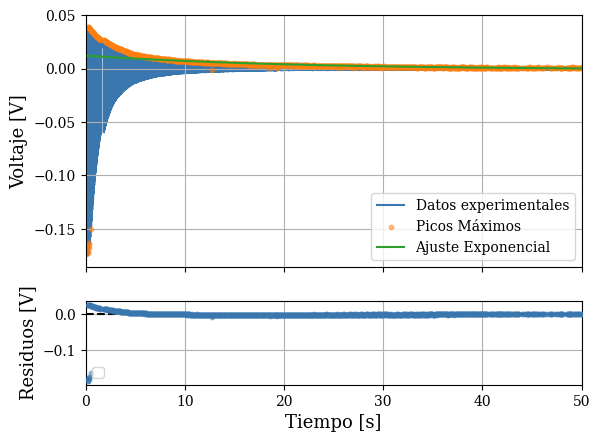

In [110]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max = np.linspace(min(t8_max), max(t8_max), 1000)

popt_max, pcov_max = curve_fit(
    exponencial, t8_max, V8_max,
    p0=[max(V8_max), 0.1, min(V8_max)], sigma=errorVmax)

V_fit_max = exponencial(t_fit_max, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

residuos_max = V8_max - exponencial(t8_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(t8, v8, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t8_max, V8_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max, V_fit_max, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].set_xlim(0,50)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t8_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t8_max, *popt_max)
residuos = V8_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

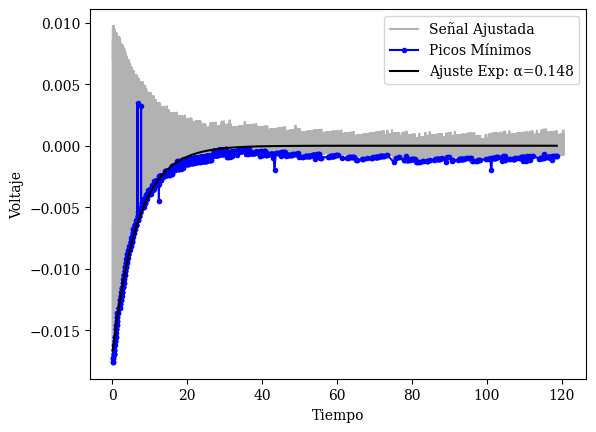

α=0.148 ± 0.001


In [111]:
def exp_decay(t, A, alpha):
    return A * np.exp(-alpha * t)

popt, pcov = curve_fit(exp_decay, t3_min, V3_min, p0=[max(V3_min), 0.1])
A_fit, alpha_fit = popt

# Calcular el error de alpha a partir de la matriz de covarianza
alpha_error = np.sqrt(pcov[1, 1])

t_fit = np.linspace(min(t3_min), max(t3_min), 100)
V_fit = exp_decay(t_fit, *popt)

plt.plot(t3, v3, label="Señal Ajustada", color='gray', alpha=0.6)
plt.plot(t3_min, V3_min, label='Picos Mínimos', color='blue', marker='.')
plt.plot(t_fit, V_fit, label=f'Ajuste Exp: α={alpha_fit:.3f}', color='black')

plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.legend()
plt.show()

print(f'α={alpha_fit:.3f} ± {alpha_error:.3f}')

alfa 0.18033029367048528
Ajuste para picos máximos:
A = 0.0323, α = 0.1803 +- 0.0013, C = 0.0015
Chi-cuadrado (χ²): 81.4971
Chi-cuadrado reducido (χ²/ν): 0.0658
p-valor: 1.0000


<ipython-input-112-5f833a1d4998>:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


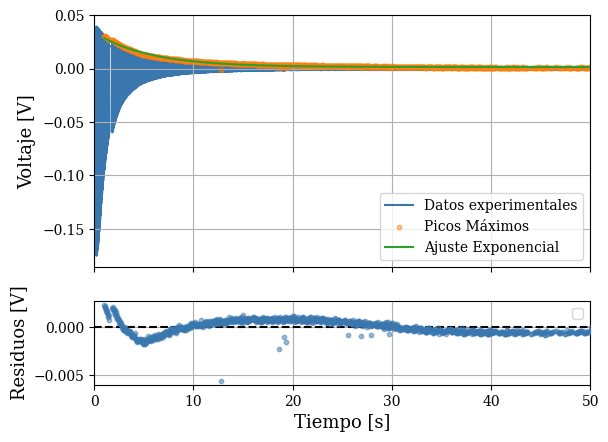

In [112]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

# Filtrar picos eliminando valores extremos
if len(V8_max) > 0:
    V_median = np.median(V8_max)
    desv = np.std(V8_max)
    mascara = (V8_max > V_median - 2 * desv) & (V8_max < V_median + 2 * desv)
    t8_max_filtrado = t8_max[mascara]
    V8_max_filtrado = V8_max[mascara]
else:
    t8_max_filtrado = np.array([])
    V8_max_filtrado = np.array([])

# Calculate errorVmax after filtering V8_max:
errorVmax = np.maximum(calculate_absolute_accuracy(V8_max_filtrado), np.std(V8_max_filtrado)/10)

if len(t8_max_filtrado) > 0:
    t_fit_max = np.linspace(min(t8_max_filtrado), max(t8_max_filtrado), 1000)

    popt_max, pcov_max = curve_fit(
        exponencial, t8_max_filtrado, V8_max_filtrado,
        p0=[max(V8_max_filtrado), 0.1, min(V8_max_filtrado)], sigma=errorVmax # Use the filtered errorVmax
    )

    V_fit_max = exponencial(t_fit_max, *popt_max)
    erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
    alfamax = popt_max[1]


    residuos_max = V8_max_filtrado - exponencial(t8_max_filtrado, *popt_max)

    fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1[0].plot(t8, v8, color="#3a77af", label='Datos experimentales', zorder=1)
    ax1[0].scatter(t8_max_filtrado, V8_max_filtrado, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
    ax1[0].plot(t_fit_max, V_fit_max, color='#2ca02c', label='Ajuste Exponencial', zorder=3)
    ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
    ax1[0].set_xlim(0, 50)
    ax1[0].grid()
    ax1[0].legend()

    ax1[1].axhline(0, color='black', linestyle='--')
    ax1[1].scatter(t8_max_filtrado, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
    ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
    ax1[1].set_ylabel('Residuos [V]', fontsize=13)
    ax1[1].grid()
    ax1[1].legend()

    print("alfa", popt_max[1])

    y_predicho = exponencial(t8_max_filtrado, *popt_max)
    residuos = V8_max_filtrado - y_predicho
    error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

    chi2_valor = np.sum((residuos / errorVmax) ** 2)
    dof = len(t8_max_filtrado) - len(popt_max)
    chi2_reducido = chi2_valor / dof
    p_valor = chi2.sf(chi2_valor, dof)

    print("Ajuste para picos máximos:")
    print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
    print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
    print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
    print(f"p-valor: {p_valor:.4f}")
else:
    print("⚠ No se pudo realizar el ajuste porque no se encontraron suficientes picos máximos.")


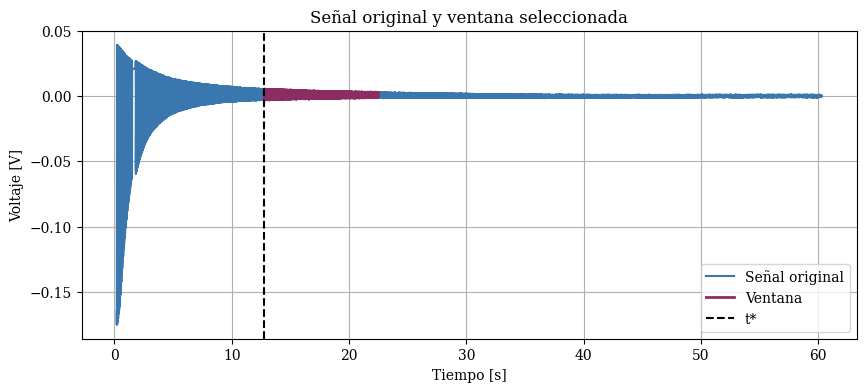

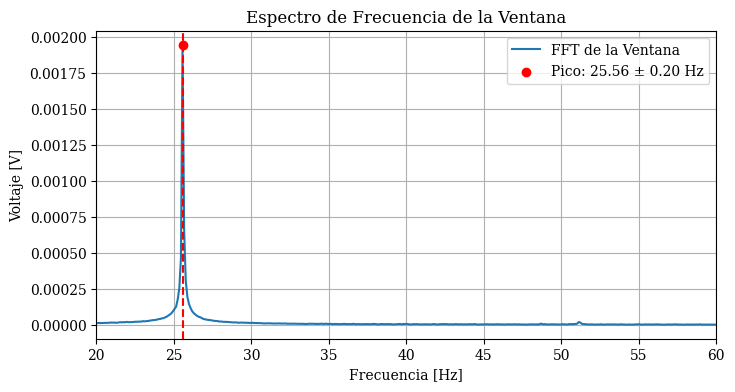

In [113]:
alfamax = popt_max[1]
t_star = -np.log(0.1) / alfamax

frecuencias, fft_resultado = calcular_transformada_fourier(t8, v8)

picos, propiedades = find_peaks(fft_resultado, height=np.max(fft_resultado) * 0.5, prominence=np.max(fft_resultado) * 0.1)
indice_frecuencia_dominante = picos[np.argmax(propiedades['peak_heights'])]
f_estimada = frecuencias[indice_frecuencia_dominante]

altura_max = np.max(fft_resultado)
mitad_altura = altura_max / 2

indices_mitad = np.where(fft_resultado >= mitad_altura)[0]
ancho_mitad = frecuencias[indices_mitad[-1]] - frecuencias[indices_mitad[0]]

error_f = ancho_mitad

N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(t8, t_star)
idx_end = idx_start + int(N * T * (len(t8) / max(t8)))

ventana = v8[idx_start:idx_end]
t_ventana = t8[idx_start:idx_end]

frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

plt.figure(figsize=(10, 4))
plt.plot(t8, v8, label="Señal original", color='#3a77af')
plt.plot(t_ventana, ventana, label="Ventana", linewidth=2, color="#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, label="FFT de la Ventana")
plt.scatter(f_estimada_ventana, np.max(fft_resultado_ventana), color='red', zorder=3, label=f"Pico: {f_estimada_ventana:.2f} ± {error_f:.2f} Hz")
plt.axvline(f_estimada_ventana, color='red', linestyle='--')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(20, 60)
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.legend()
plt.grid()
plt.show()

In [114]:
L = 22.7/100
alpha = 0.1803 # +- 0.0013
d = 0.5/100
rho = (77/1000)*(1/(L))  #del cobr  # kg/m

f = 25.56

L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 0.2 #
alpha_err = 0.0013 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alpha, alpha_err)
d_u = ufloat(d , d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(f, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + (alfa_u)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 61.26+/-1.53 GPa


## Med 5 - 20-2-25 latón L=17.7 cm

In [115]:
def cargar_datos_csv(archivo):
    data = pd.read_csv(archivo, skiprows=1, delimiter=",", decimal=".", header=None)
    tiempos = np.asarray(data[0])
    voltajes = np.asarray(data[1])
    return tiempos, voltajes

In [116]:
tiempo, voltaje = cargar_datos_csv("5MedFotodiodo-conirisA13MASTIEMPOL17-7cm0.csv")

FileNotFoundError: [Errno 2] No such file or directory: '5MedFotodiodo-conirisA13MASTIEMPOL17-7cm0.csv'

In [ ]:
from scipy.signal import savgol_filter

#Si la señal es muy ruidosa y es necesario se puede filtrar un poco la señal:
# V_smooth = savgol_filter(V, window_length=11, polyorder=2)  # Suaviza manteniendo forma de la señal, cambiar voltajes por V_smooth
#Encontrar picos máximos
voltaje = voltaje - np.mean(voltaje)
peaks_max, _ = find_peaks(voltaje, prominence=0.05)
peaks_min, _ = find_peaks(-voltaje, prominence=0.05)# Para mínimos, buscamos picos en la señal invertida

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = voltaje[peaks_max]

t_min = tiempo[peaks_min]
V_min = voltaje[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(tiempo, voltaje, label='Datos originales', color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit3 = np.linspace(min(tiempo), max(tiempo), 1000)

# Seleccionar los picos correspondientes a t > 20 s
mask_20s = t_max >= 10

# Calcular la desviación estándar solo para esos picos
std_post20s = np.std(V_max[mask_20s])*1.1

# Definir el error como el máximo entre la precisión absoluta y esta nueva desviación estándar
errorVmax = np.maximum(calculate_absolute_accuracy(V_max), std_post20s)

#errorVmax = np.maximum(calculate_absolute_accuracy(V_max), np.std(V_max)/10)  # Evitar incertidumbres subestimadas
#errorVmin = np.maximum(calculate_absolute_accuracy(V_min), np.std(V_min)/10)

#errorVmax = calculate_absolute_accuracy(V_max)

#----------Máximos-----------
#C = np.mean(V_max[int(len(V_max) * 0.8):])
C = min(V_max)

popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max3 = exponencial(t_fit3, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, voltaje, color="#3a77af", label='Datos experimentales', zorder=1)
ax[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax[0].plot(t_fit3, V_fit_max3, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid()
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--')
ax[1].scatter(t_max, residuos, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[1].set_ylabel('Residuos [V]', fontsize=13)
ax[1].grid()
ax[1].legend()

# Guardar como SVG
plt.savefig('med5ajusteexponencial.svg', format='svg')

plt.show()

In [ ]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit_max = np.linspace(min(t_max), max(t_max), 1000)

"""
C_init_max = np.mean(V_max[int(len(V_max) * 0.8):])

A_init_max = np.max(V_max) - C_init_max

popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[A_init_max, 0.5, C_init_max],
    absolute_sigma=True
)
"""
popt_max, pcov_max = curve_fit(
    exponencial, t_max, V_max,
    p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)

V_fit_max = exponencial(t_fit_max, *popt_max)

residuos_max = V_max - exponencial(t_max, *popt_max)

fig1, ax1 = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1[0].plot(tiempo, voltaje, color="#3a77af", label='Datos experimentales', zorder=1)
ax1[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax1[0].plot(t_fit_max, V_fit_max, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax1[0].set_ylabel('Voltaje [V]', fontsize=13)
ax1[0].grid()
ax1[0].legend()

ax1[1].axhline(0, color='black', linestyle='--')
ax1[1].scatter(t_max, residuos_max, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax1[1].set_xlabel('Tiempo [s]', fontsize=13)
ax1[1].set_ylabel('Residuos [V]', fontsize=13)
ax1[1].grid()
ax1[1].legend()

print("alfa", popt_max[1])

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

In [ ]:
#Codigo para tomar N periodos
# Determinar t* donde la señal ha decaído al 10% de la inicial
t_star = -np.log(0.1) / alfamax

# Aplicar FFT a toda la señal para estimar la frecuencia dominante
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, voltaje)

# Encontrar la frecuencia dominante
indice_frecuencia_dominante = np.argmax(fft_resultado)
f_estimada = frecuencias[indice_frecuencia_dominante]  # Usamos la frecuencia dominante estimada

print(f"Frecuencia estimada: {f_estimada:.2f} Hz")
# Seleccionar N períodos desde t*
N = 250
T = 1 / f_estimada
idx_start = np.searchsorted(tiempo, t_star)
idx_end = idx_start + int(N * T * (len(tiempo) / max(tiempo)))  # Ajustamos por la resolución temporal

ventana = voltaje[idx_start:idx_end]
t_ventana = tiempo[idx_start:idx_end]

# Aplicar FFT sobre la ventana seleccionada
frecuencias_ventana, fft_resultado_ventana = calcular_transformada_fourier(t_ventana, ventana)
indice_frecuencia_dominante_ventana = np.argmax(fft_resultado_ventana)
f_estimada_ventana = frecuencias_ventana[indice_frecuencia_dominante_ventana]

# Graficar la señal original y la ventana seleccionada
plt.figure(figsize=(10, 4))
plt.plot(tiempo, voltaje, color="#3a77af", label='Datos experimentales')
plt.plot(t_ventana, ventana, label="Datos seleccionados", linewidth=2, color = "#8B2C62")
plt.axvline(t_star, color='black', linestyle='--', label="t*")
plt.legend()
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Señal original y ventana seleccionada")
plt.grid()
plt.show()

# Graficar la FFT de la ventana
plt.figure(figsize=(8, 4))
plt.plot(frecuencias_ventana, fft_resultado_ventana, color = "#3a77af", linewidth=2)
plt.xlabel("Frecuencia [Hz]")
plt.xlim(40,60)
plt.axvline(f_estimada_ventana, color='black', linestyle='--', label="t*")
plt.ylabel("Voltaje [V]")
plt.title("Espectro de Frecuencia de la Ventana")
plt.grid()
plt.show()

In [ ]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = calculate_absolute_accuracy(V_max)
errorVmin = calculate_absolute_accuracy(V_min)

#----------Máximos-----------
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")


plt.scatter(tiempo, voltaje, color="lightblue",  label='Datos experimentales', s=1)
plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('Voltaje [V]', fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

plt.plot(tiempo[5000:10000], voltaje[5000:10000],'o',label='Datos experimentales', color="lightblue")
plt.grid(True)
plt.show()

In [ ]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, voltaje)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.title('Transformada de Fourier', fontsize = 13)
plt.xlabel('Frecuencia [Hz]', fontsize = 13)
plt.xlim(45, 55)
plt.ylabel('Amplitud [V]' , fontsize = 13)
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [ ]:
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 17.7/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

In [ ]:
L_err = 0.3/100
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(17.7/100)), rho_err)
L_u = ufloat(17.7/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

print(E_GPa_u)
print(f_err)

# exponenciales


In [ ]:
L = np.array([37, 30, 30])/100
E = np.array([173.20, 205.20, 204.73])


In [ ]:
plt.plot(t_fit_max1, V_fit_max1, color = '#0000FF', label='L = (37 $\pm$ 0.1)cm', zorder=3)  # Azul
plt.plot(t_fit_max2, V_fit_max2, color = '#FF0000', label='L = (30 $\pm$ 0.1)cm', zorder=3)  # Rojo
plt.plot(t_fit_max3, V_fit_max3, color = '#FF7F00', label='L = (30 $\pm$ 0.1)cm', zorder=3)  # Naranja

plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('Voltaje [V]', fontsize=13)
plt.grid()
plt.legend()

# Porcentaje de decaimiento


In [ ]:
peaks_max, _ = find_peaks(v2, prominence=0.002)

t2_max = t2[peaks_max]
V2_max = v2[peaks_max]

voltaje = voltaje - np.mean(voltaje)
peaks_max, _ = find_peaks(voltaje, prominence=0.05)
peaks_min, _ = find_peaks(-voltaje, prominence=0.05)

t_max = tiempo[peaks_max]
V_max = voltaje[peaks_max]

t_max = tiempo[peaks_max]
V_max = voltaje[peaks_max]


A02 = V2_max[0]
A0 = V_max[0]

porcentaje_decaimiento2 = (1 - (V2_max / A02)) * 100
porcentaje_decaimiento = (1 - (V_max / A0)) * 100

plt.figure(figsize=(8, 5))
plt.scatter(t_max, porcentaje_decaimiento, color="red", label="Latón")
plt.scatter(t2_max, porcentaje_decaimiento2, color="blue", label="Acero")
plt.axhline(100, color='gray', linestyle="--")
plt.xlabel("Tiempo [s]")
plt.ylabel("Decaimiento de Amplitud [%]")
plt.title("Porcentaje de decaimiento de la amplitud en función del tiempo")
plt.legend()
plt.grid()
plt.show()

#Laton

In [117]:
#calculo error daq

def calculate_absolute_accuracy(reading):
    # Example values from the table for the 10V range
    range_value = 10  # Nominal range positive full scale
    residual_gain_error = 75*(10**-6)  # ppm of reading
    gain_tempoo = 7.3*(10**-6)  # ppm/°C
    temp_change_internal_cal = 5  # Example temperature change in °C
    reference_tempoo = 5*(10**-6)  # ppm/°C
    temp_change_external_cal = 5  # Example temperature change in °C
    residual_offset_error = 20*(10**-6)  # ppm of range
    offset_tempoo = 34*(10**-6)  # ppm of range/°C
    inl_error = 76*(10**-6)  # ppm of range
    random_noise = 295*(10**-6)  # µVrms

    # Calculate GainError
    gain_error = residual_gain_error + gain_tempoo * temp_change_internal_cal + reference_tempoo * temp_change_external_cal

    # Calculate OffsetError
    offset_error = residual_offset_error + offset_tempoo * temp_change_internal_cal + inl_error

    # Calculate NoiseUncertainty
    noise_uncertainty = (random_noise * 3) / 100

    # Calculate Absolute Accuracy
    absolute_accuracy = reading * gain_error + range_value * offset_error + noise_uncertainty

    return absolute_accuracy

##Medición 7

In [118]:
tiempo, voltaje = cargar_datos_csv("7MedFotodiodo-conirisA13-50seg-L29-2cm0.csv")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


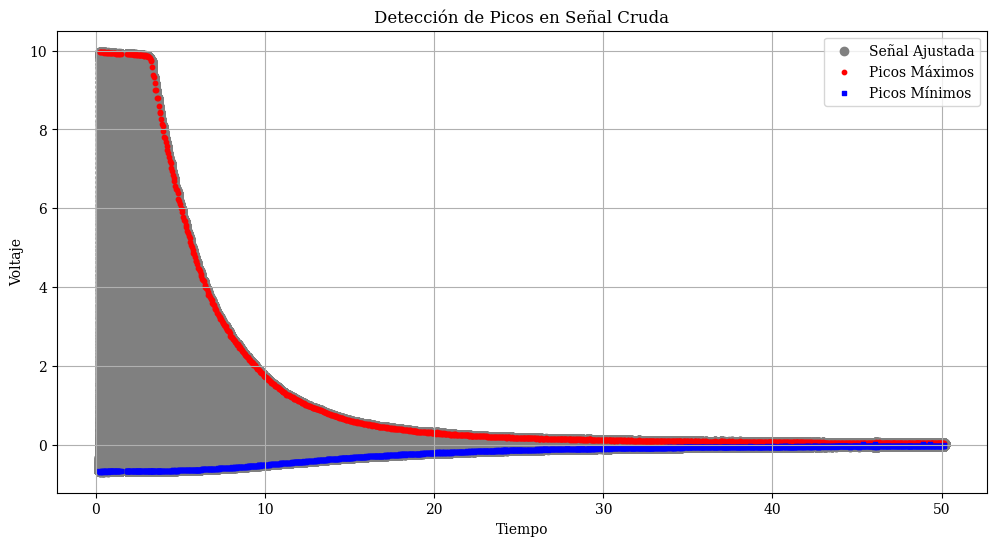

In [119]:
from scipy.signal import savgol_filter


num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(voltaje[-num_puntos_finales:])
V_ajustada = voltaje - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=30)

#Crear listas con los valores de los picos
t_max = tiempo[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = tiempo[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.scatter(tiempo, V_ajustada, label="Señal Ajustada", color='gray')
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

Ajuste para picos máximos:
A = 13.6601, α = 0.1861 +- 0.0018, C = 0.0010
Chi-cuadrado (χ²): 19786098.0527
Chi-cuadrado reducido (χ²/ν): 17027.6231
p-valor: 0.0000


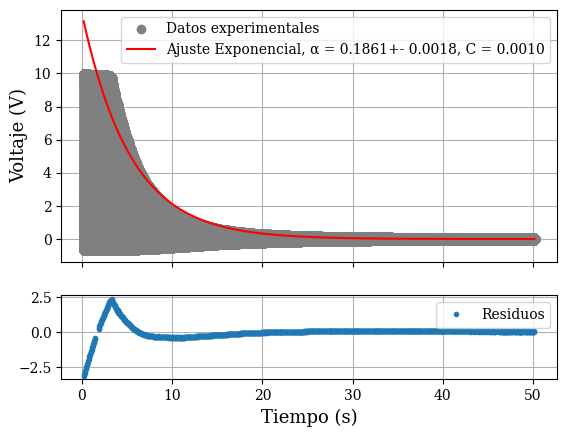


Ajuste para picos mínimos:
A = -0.8731, α = 0.0533+- 0.0008, C = 0.0598
Chi-cuadrado (χ²): 258544.5200
Chi-cuadrado reducido (χ²/ν): 185.6027
p-valor: 0.0000


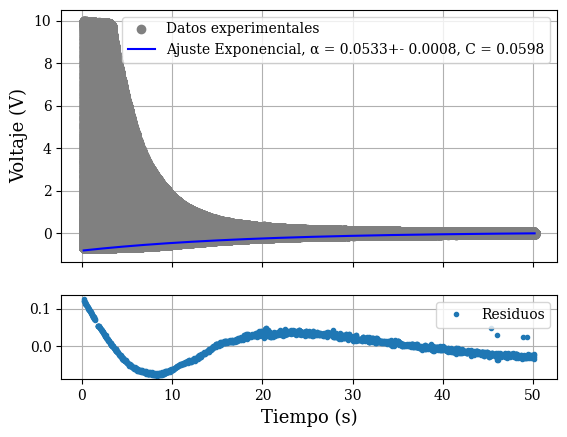

In [120]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = calculate_absolute_accuracy(V_max)
errorVmin = calculate_absolute_accuracy(V_min)

#----------Máximos-----------
popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max = exponencial(t_fit, *popt_max)
erroralfa_max = np.sqrt(np.diag(pcov_max))[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada,'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_max, 'r-', label=f'Ajuste Exponencial, α = {popt_max[1]:.4f}+- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}')
ax[1].errorbar(t_max, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

#----------Mínimos-----------
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, 'o', label='Datos experimentales', color="grey")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo (s)', fontsize=13)
ax[0].set_ylabel('Voltaje (V)', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

Ajuste para picos máximos:
A = 13.3811, α = 0.1755 +- 0.0020, C = -0.0392
Chi-cuadrado (χ²): 4111.6474
Chi-cuadrado reducido (χ²/ν): 3.5384
p-valor: 0.0000


<ipython-input-121-673dd6498a99>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


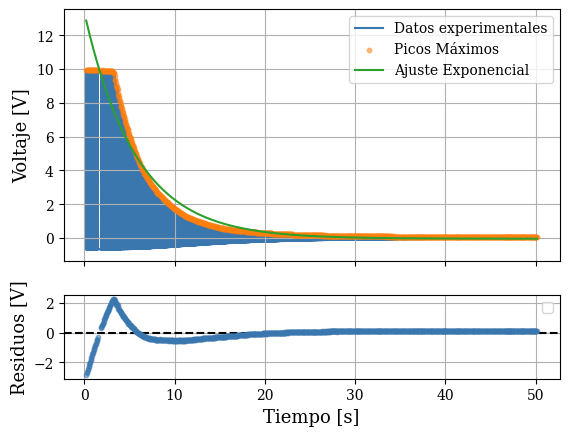

'\n#----------Mínimos-----------\npopt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)\n\nV_fit_min = exponencial(t_fit, *popt_min)\nerroralfa_min = np.sqrt(np.diag(pcov_min))[1]\n\n# Predicción y residuos\ny_predicho = exponencial(t_min, *popt_min)\nresiduos = V_min - y_predicho\n\n# Cálculo del Chi-cuadrado\nchi2_valor = np.sum((residuos / errorVmin) ** 2)\ndof = len(t_min) - len(popt_min)  # Grados de libertad\nchi2_reducido = chi2_valor / dof\np_valor = chi2.sf(chi2_valor, dof)\n\n#Resultados\nprint("\nAjuste para picos mínimos:")\nprint(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")\nprint(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")\nprint(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")\nprint(f"p-valor: {p_valor:.4f}")\n\n# Gráficos\nfig, ax = plt.subplots(2, sharex=True, gridspec_kw={\'height_ratios\': [3, 1]})\n\nax[0].plot(tiempo, voltaje, \'o\', label=\'Datos experimentales

In [121]:
def exponencial(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

t_fit5 = np.linspace(min(tiempo), max(tiempo), 1000)

errorVmax = np.maximum(calculate_absolute_accuracy(V_max), np.std(V_max)/10)  # Evitar incertidumbres subestimadas

#----------Máximos-----------
#C = np.mean(V_max[int(len(V_max) * 0.8):])
C = min(V_max)

popt_max, pcov_max = curve_fit(exponencial, t_max, V_max, p0=[max(V_max), 0.1, min(V_max)], sigma=errorVmax)
V_fit_max5 = exponencial(t_fit5, *popt_max)

erroralfa_max = np.sqrt(np.diag(pcov_max))[1]
alfamax=popt_max[1]

# Predicción y residuos
y_predicho = exponencial(t_max, *popt_max)
residuos = V_max - y_predicho
error_residuos = (errorVmax**2 + erroralfa_max**2)**(1/2)

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmax) ** 2)
dof = len(t_max) - len(popt_max)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

# Impresión de resultados
print("Ajuste para picos máximos:")
print(f"A = {popt_max[0]:.4f}, α = {popt_max[1]:.4f} +- {erroralfa_max:.4f}, C = {popt_max[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, V_ajustada, color="#3a77af", label='Datos experimentales', zorder=1)
ax[0].scatter(t_max, V_max, color='#ff7f0e', alpha=0.5, label='Picos Máximos', s=10, zorder=2)
ax[0].plot(t_fit5, V_fit_max5, color = '#2ca02c', label='Ajuste Exponencial', zorder=3)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid()
ax[0].legend()

ax[1].axhline(0, color='black', linestyle='--')
ax[1].scatter(t_max, residuos, color='#3a77af', alpha=0.5, s=10, zorder=3)
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[1].set_ylabel('Residuos [V]', fontsize=13)
ax[1].grid()
ax[1].legend()
plt.show()
"""
#----------Mínimos-----------
popt_min, pcov_min = curve_fit(exponencial, t_min, V_min, p0=[min(V_min), 0.1, max(V_min)],sigma=errorVmin)

V_fit_min = exponencial(t_fit, *popt_min)
erroralfa_min = np.sqrt(np.diag(pcov_min))[1]

# Predicción y residuos
y_predicho = exponencial(t_min, *popt_min)
residuos = V_min - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorVmin) ** 2)
dof = len(t_min) - len(popt_min)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

#Resultados
print("\nAjuste para picos mínimos:")
print(f"A = {popt_min[0]:.4f}, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(tiempo, voltaje, 'o', label='Datos experimentales', color="grey")
# ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial, α = {popt_min[1]:.4f}+- {erroralfa_min:.4f}, C = {popt_min[2]:.4f}', color="blue")
ax[0].plot(t_fit, V_fit_min, label=f'Ajuste Exponencial', color="blue")
ax[1].axhline(0, color = "black")
ax[1].errorbar(t_min, residuos, fmt=".", label="Residuos")
ax[1].set_xlabel('Tiempo [s]', fontsize=13)
ax[0].set_ylabel('Voltaje [V]', fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()
"""

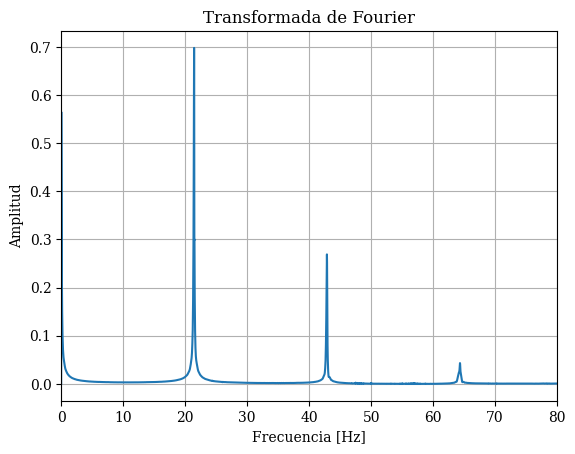

Frecuencia dominante: 21.442793769343695 Hz
Amplitud dominante: 0.6978019350749382 V


In [122]:
frecuencias, fft_resultado = calcular_transformada_fourier(tiempo, V_ajustada)

# Graficar el resultado
plt.figure()
plt.plot(frecuencias, fft_resultado)
plt.title('Transformada de Fourier')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 80)
plt.ylabel('Amplitud')
plt.grid()
plt.show()

#OBS: la amplitud puede parecer rara que este tan baja pero es porque le reste la media así quedaba en 0

# Encontrar la frecuencia dominante y su amplitud
indice_frecuencia_dominante = np.argmax(fft_resultado)
frecuencia_dominante = frecuencias[indice_frecuencia_dominante]
amplitud_dominante = fft_resultado[indice_frecuencia_dominante]

print(f"Frecuencia dominante: {frecuencia_dominante} Hz")
print(f"Amplitud dominante: {amplitud_dominante} V")

In [123]:
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = 8960 * (np.pi * (d / 2) ** 2)  #del cobre
I = (np.pi * (d)**4)/64
L = 29.2/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)
print("rho", rho)
print("I", I)
print("k", k)

NameError: name 'alfamin' is not defined

In [ ]:
# NO asumimos que es completamente cobre
alfa = (alfamax + alfamin)*0.5
d = 0.5/100 # en metros
rho = (77/1000)*(1/(29.2/100))  #del cobre
I = (np.pi * (d)**4)/64
L = 29.2/100 #en metros
k = 1.875/L
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print("El modulo de Young es de:", E/10**9)

In [ ]:
L_err = 0.001
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/len(frecuencias) # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza
from uncertainties import ufloat

alfa_u = ufloat((alfamax+alfamin)/2, alpha_err)
d_u = ufloat(0.5/100, d_err)
rho_u = ufloat((77/1000)*(1/(29.2/100)), rho_err)
L_u = ufloat(29.2/100, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + ((alfamax+alfamin)/2)**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u

In [ ]:
L = np.array([ 25.6, 23.5, 17.7, 13.0, 29.2])/100 #longitudes de la varilla de cobre
#x_cobre = np.array([23.5, 17.7, 13.0]) /100 #longitudes de la varilla de cobre en metros
E = np.array([96.74211353981278, 101.61360123436677, 107.40628343180688,  119.3951186347018, 91.77133799875648 ]) #E que calculamos / longitud de la medición
#y_cobre = np.array([ 101.61360123436677, 107.40628343180688,  119.3951186347018 ]) #E que calculamos / longitud de la medición
alfa = ([])
rho = ([])
d =([])


# Todas juntas

In [ ]:
plt.plot(t_fit5, V_fit_max5, color = '#0000FF', label='L_{acero} = (29.2 $\pm$ 0.1)cm' , zorder=3)  # Azul
# plt.plot(t_fit_max1, V_fit_max1, color = '#FF0000', label='L = (25.6 $\pm$ 0.1)cm', zorder=3)  # Rojo
# plt.plot(t_fit_max2, V_fit_max2, color = '#FF7F00', label='L = (23.5 $\pm$ 0.1)cm', zorder=3)  # Naranja
# plt.plot(t_fit3, V_fit_max3, color = '#FFCC00', label='L = (17.7 $\pm$ 0.1)cm', zorder=3)  # Amarillo
# plt.plot(t_fit4, V_fit_max4, color = '#66B032', label='L = (13.0 $\pm$ 0.1)cm', zorder=3)  # Verde
plt.plot(t_fit_max2, V_fit_max2, color = '#FF7F00', label='L_{laton_1} = (30.0 $\pm$ 0.1)cm', zorder=3)
plt.plot(t_fit_max3, V_fit_max3, color = '#66B032', label='L_{laton_2} = (30.0 $\pm$ 0.1)cm', zorder=3)
plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('Voltaje [V]', fontsize=13)
plt.grid()
plt.legend()
# # Guardar como SVG
# plt.savefig('exponencialestot.svg', format='svg')

plt.show()